In [142]:
import numpy as np
import pandas as pd
df = pd.DataFrame(pd.read_csv("NICU_2020.csv"))
df.head()

,MRN,DOL,dosing_weight,tpn_rate,smof_rate,other_Rate,dextrose_rate,total_rate,glucose_rate,blood_glucose
0,973456881.0,1.0,0.85,2.83,NaN,NaN,10.0,2.83,5.549,125.0
1,973456881.0,2.0,0.85,3.54,NaN,0.17,10.0,3.37,6.608,130.0
2,973456881.0,2.0,0.85,2.83,NaN,0.17,10.0,2.66,5.216,130.0
3,973456881.0,3.0,0.85,4.25,NaN,0.34,12.5,3.91,9.583,129.0
4,973456881.0,4.0,0.85,4.96,NaN,0.51,14.0,4.45,12.216,NaN


In [143]:
#remove null target data
df2 = df[df['blood_glucose'].notna()]

In [144]:
#delete uneeded columns
df_features = df2.drop(columns=['other_Rate', 'smof_rate'])

In [145]:
#create target predictor
def f(row):
    if row['blood_glucose'] > 120:
        val = 1
    else:
        val = 0
    return val
df_features['target'] = df_features.apply(f, axis=1)
df_features.head()

,MRN,DOL,dosing_weight,tpn_rate,dextrose_rate,total_rate,glucose_rate,blood_glucose,target
0,973456881.0,1.0,0.85,2.83,10.0,2.83,5.549,125.0,1
1,973456881.0,2.0,0.85,3.54,10.0,3.37,6.608,130.0,1
2,973456881.0,2.0,0.85,2.83,10.0,2.66,5.216,130.0,1
3,973456881.0,3.0,0.85,4.25,12.5,3.91,9.583,129.0,1
5,973456881.0,5.0,0.85,5.31,14.0,4.80,13.176,124.0,1


In [146]:
#drop null values
df_features = df_features[df_features['tpn_rate'].notna()]

In [147]:
#define features and targets
X = df_features
Y = df_features["target"]
#make test/train split in data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30)

In [148]:
#remove target from predictor data
del X_train["target"]
del X_test["target"]

In [149]:
#remove extraneous info
del X_train["MRN"]
del X_test["MRN"]

In [150]:
#remove confounding column
del X_train["blood_glucose"]
del X_test["blood_glucose"]

In [151]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
import matplotlib.pyplot as plt

In [152]:
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [153]:
#built in accuracy score
forest.score(X_test, y_test)

0.7405764966740577

In [154]:
# Actual class predictions
rf_predictions = forest.predict(X_test)
# Probabilities for each class
rf_probs = forest.predict_proba(X_test)[:, 1]

from sklearn.metrics import roc_auc_score

# Calculate roc auc
roc_value = roc_auc_score(y_test, rf_probs)
print(roc_value)

0.7813625050002222


In [155]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

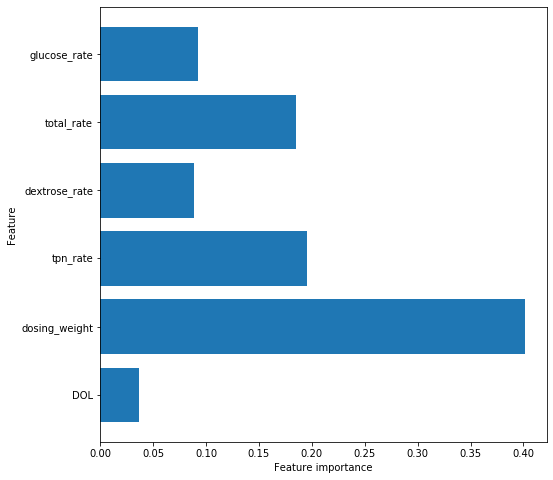

In [156]:
plot_feature_importances(forest)

Area under the ROC here demonstrates 78% accuracy in predicting the patients class (glucose intolerance or not) based on the input variables. Note that the input variables in order of importance are:

1) dosing weight
2) tpn rate
3) total rate
4) glucose rate
5) dextrose rate
6) day of life